In [1]:
from math import exp, sqrt, pi
import numpy as np
import pandas as pd

k = 3
R = 10
mu = np.linspace(-0.75*R, 0.75*R, k+1)[:-1] + np.random.uniform(0, 1.5*R/k, k)
sigma = R/12 * np.random.uniform(1,2,k)
lamb = np.ones(k) + np.random.dirichlet(0.3 * np.ones(k))
lamb /= lamb.sum()

print(mu,sigma,lamb,sep='\n')
def p(x):
    pdfs = [lamb[i] * exp(-0.5 * (x - mu[i])**2 / sigma[i]**2) / sqrt(2*pi) / sigma[i] for i in range(k)]
    return sum(pdfs)

[-6.15704105 -1.64519625  6.13030246]
[0.96604103 1.63638796 0.9911823 ]
[0.37809292 0.36926487 0.25264221]


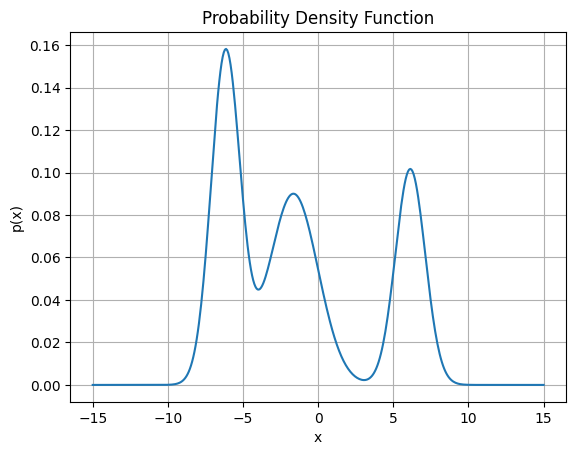

In [2]:
import matplotlib.pyplot as plt

x_grid = np.linspace(-1.5*R, 1.5*R, 400)
y = [p(val) for val in x_grid]

plt.plot(x_grid, y)
plt.title('Probability Density Function')
plt.xlabel('x')
plt.ylabel('p(x)')
plt.grid(True)
plt.show()

The above pdf is a pdf of mixture of Gaussian model.

Consider a general pdf, like MoG density with unknown paramters, how to sample from it? We always assume we have random generator of uniform distributions. 

### Traditional Methods

If cdf has an explicit inverse, we can sample by composing inverse cdf. 

E.g. sampling exponential distributions. cdf $F(x) = 1- e^{-x}$, inverse cdf $G(u) = -\log(1-u)$


<Axes: >

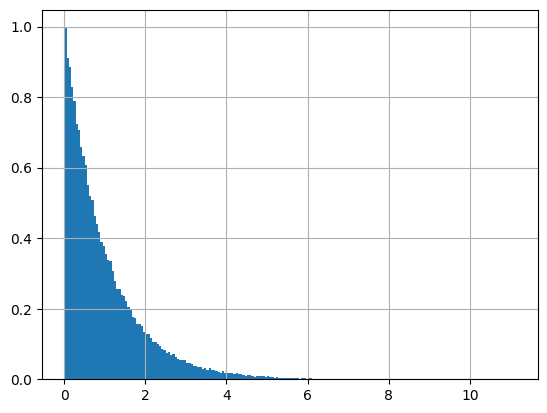

In [3]:
x = np.random.rand(100000)
y = -np.log(1-x)
pd.Series(y).hist(bins=200, density=True)

Let's assume the pdf p(x) is bounded above by M. Then we can use another distribution q that we know how to sample ot cover p. I.e. Find a M such that $p(x) \leq Mq(x)$ for all x. Then we can sample q instead, and for each sample, we adjust the sample by sample another a uniform distribution, comparing it with $p/Mq$, and decide to keep it or not.  This method requires we know the (range of) the maximal of $p$.


This methods works well for sampling from analytically tractable distributions, say sampling normal from exponential.

  0%|          | 0/100000 [00:00<?, ?it/s]

Total accept_rate: 75.87


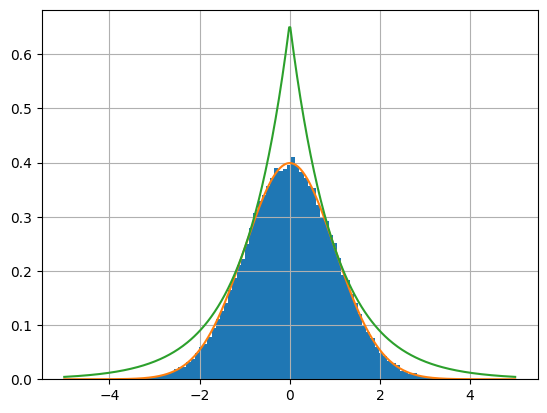

In [4]:
# example to sample normal using exponential distribution
from tqdm.notebook import tqdm

N_samples = 100000
samples = []


def q(x,s):
    return 1/( 2 * pi) ** 0.5/s * exp( - x ** 2 / 2 / s**2)

x_grid = np.linspace(-5, 5, 400)
M = max([2*q(val,1)/exp(-val) for val in np.abs(x_grid)])
for i in tqdm(range(N_samples)):
    x = np.random.exponential(1)
    sign = np.random.choice([-1,1])
    u = np.random.uniform()
    if u < 2*q(x,1)/(exp(-x)*M):
        samples.append(x * sign)

print(f"Total accept_rate: {100* len(samples)/N_samples:.2f}")
pd.Series(samples).hist(bins=100, density=True)
plt.plot(x_grid, [q(val,1) for val in x_grid])
plt.plot(x_grid, [exp(-val)/2 * M for val in np.abs(x_grid)])


The issue for this method is that 
- requires the computation of $M$, sometimes we don't have a good bound of $p$
- many sample wasted in the rejection part, becomes an issue when dimension increases : sampling efficiency multiplies

M: 4.795296823919329


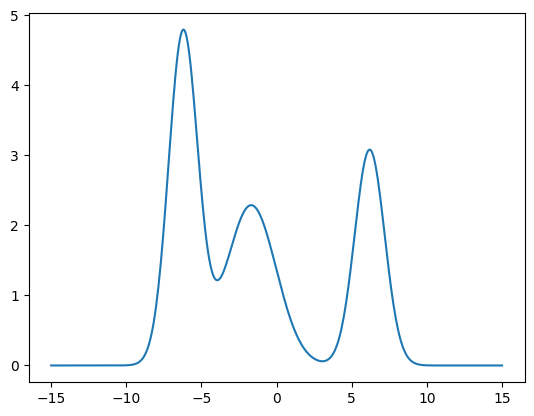

In [5]:


x_grid = np.linspace(-1.5*R, 1.5*R, 400)
y = [p(val) for val in x_grid]

s = 10
M = max([p(val) / q(val,s) for val in x_grid])
plt.plot(x_grid, [p(val)/ q(val,s) for val in x_grid], label='M*q(x)')
print('M:', M)

  0%|          | 0/100000 [00:00<?, ?it/s]

Total accept_rate: 20.93


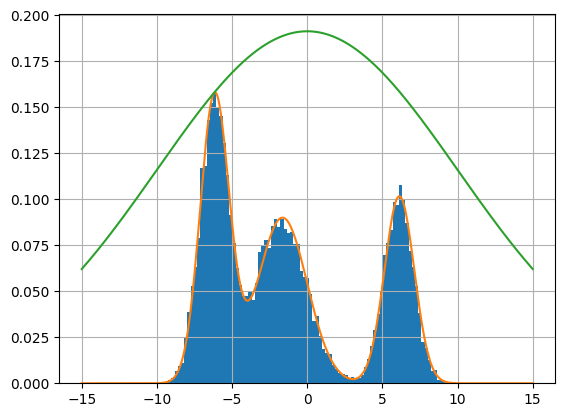

In [6]:
from tqdm.notebook import tqdm
import pandas as pd

N_samples = 100000
samples = []
for i in tqdm(range(N_samples)):
    x = s*np.random.randn()
    u = np.random.uniform()
    if u < p(x)/(q(x,s) * M):
        samples.append(x)
print(f"Total accept_rate: {100* len(samples)/N_samples:.2f}")
pd.Series(samples).hist(bins=100, density=True)
plt.plot(x_grid, y)
plt.plot(x_grid, [M*q(val,s) for val in x_grid], label='q(x)')
plt.show()

### MCMC

Metropolis Sampling

Given a unnormalized distribution $p$, consider construct a Markov kernal $p(x,x')$ such that whose stable distribution is $p$. Pick initial symmetric transition kernal $T(x,x')$ is Gaussian kernal and modify it by $p(x,x') = T(x,x')A(x,x')$, where $A(x,x') = \min(1, \frac{p(x)}{p(x')})$. By detailed balanced condition, $p$ is a stable distribution of $p(x,x')$.

Consider the case where the true pdf is of the form $p(x) = e^{f(x)}/Z$ where $Z$ is unknown or hard to compute. 
1. (Avoid Z computation) Metropolis algorithm effectively We then can use $g(x) = e^f(x)$ as our proposed distribution, as $p(x)/p(x') = g(x)/g(x')$.  
2. (Convergence) As $p$ is always positive, it is guaranteed that the Metropolis algorithm converge to $p(x)$, see [reference](https://chatgpt.com/share/6814e634-27cc-8001-8d0c-ed8316b89472). 

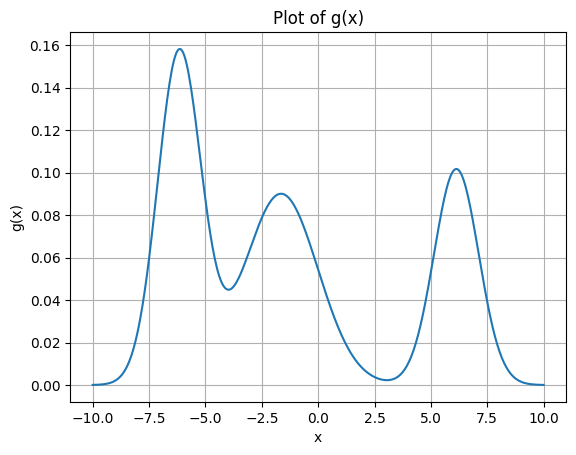

In [66]:
def g(x):
    return p(x)
x_vals = np.linspace(-R, R, 400)
g_vals = [g(x) for x in x_vals]

plt.plot(x_vals, g_vals)
plt.title('Plot of g(x)')
plt.xlabel('x')
plt.ylabel('g(x)')
plt.grid(True)
plt.show()

In [100]:
def Metropolis_Sampling(g, N_samples, proposal_std, x0=None, n_burn_in=100):
    x0 = np.random.uniform(-R, R) if x0 is None else x0
    samples = [x0]
    accept_count = 0
    for i in range(N_samples+n_burn_in):
        x_current = samples[-1]
        x_proposed = np.random.normal(x_current, proposal_std)
        acceptance_ratio = g(x_proposed) / g(x_current)
        if np.random.uniform() < acceptance_ratio:
            samples.append(x_proposed)
            accept_count += 1 if i >= n_burn_in else 0
        else:
            samples.append(x_current)
    accept_rate = accept_count / N_samples
    return samples[n_burn_in:],accept_rate



In [128]:
n_samples_list = [100, 1000, 10000, 100000]
proposal_stds = [0.5, 1.0, 4, 8]
colors = ['blue', 'turquoise', 'aquamarine','orange']
x0 = np.random.uniform(-R, R)

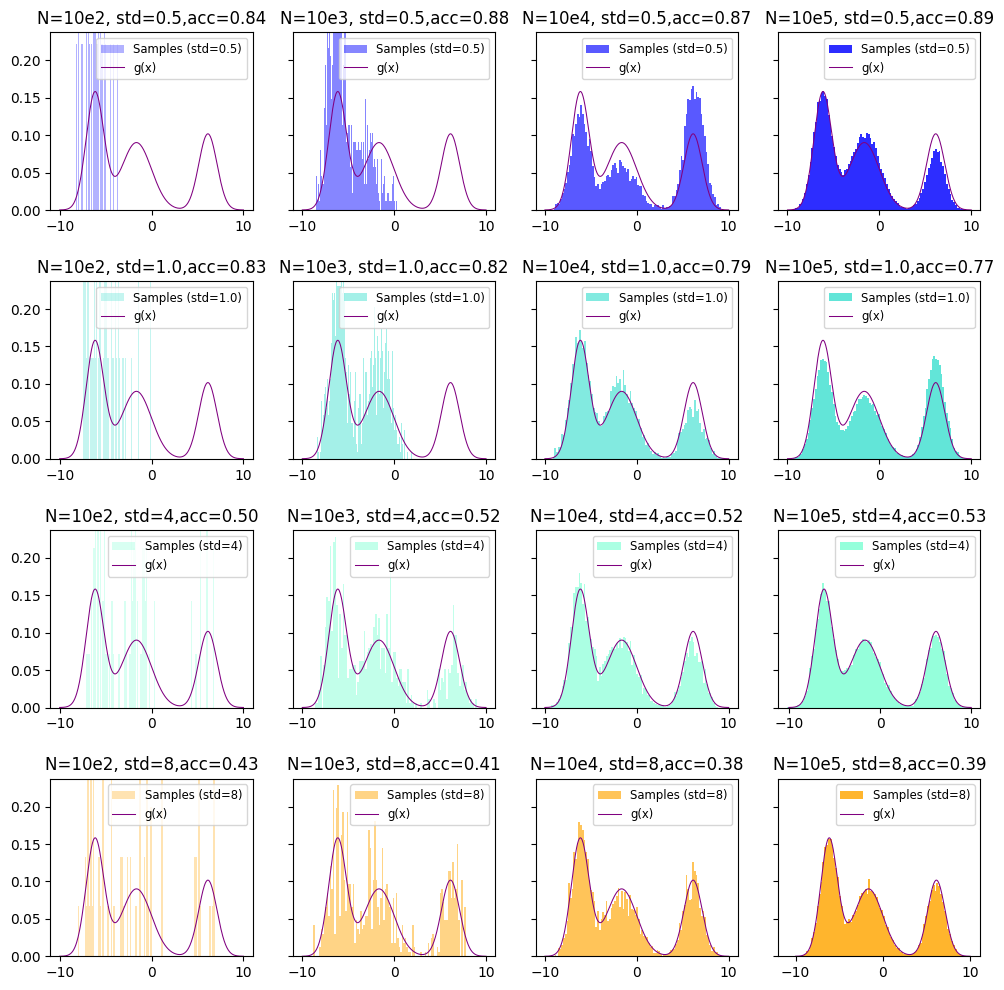

In [138]:
fig, axes = plt.subplots(len(proposal_stds),len(n_samples_list), figsize=(12, 12), sharey=True)
for row, N_samples in enumerate(n_samples_list):
    for col, proposal_std in enumerate(proposal_stds):
        x_vals_samples_range = np.linspace(-R, R, 400)
        g_vals_samples_range = [g(x) for x in x_vals_samples_range]
        samples,accept_rate = Metropolis_Sampling(g, N_samples, proposal_std, x0=x0)
        alpha = 0.3 + 0.7 * row/4  
        ax = axes[col, row]
        ax.hist(samples, bins=100, density=True, alpha=alpha, label=f'Samples (std={proposal_std})', color=colors[col])
        ax.plot(x_vals_samples_range, g_vals_samples_range, label='g(x)', color='purple', linewidth=0.75)
        ax.set_title(f'N=10e{int(np.log10(N_samples)):,}, std={proposal_std},acc={accept_rate:.2f}')
        ax.legend(fontsize='small')
        ax.set_ylim(0, 1.5 * max(g_vals_samples_range))
        fig.subplots_adjust(hspace=0.4)

Metropolis-Hastings Sampling

The requirement for the kernal $T(x,x')$ to be symmetric can be relaxed, with $A(x,x') = \min(1, \frac{p(x)T(x',x)}{p(x')T(x,x')})$. In this way, we can boost the sampling algorithm by set a proper distribution, using insights from gradient descent.

The particular choice of step size and std-deviation is called Metropolis Adjusted Langevin Algorithm (MALA).

In [ ]:
def dg(x,dx=0.001):
    return (g(x+dx) - g(x-dx)) / (2*dx)


class Transition:
    def __init__(self,std=1,eta=0.1):
        self.eta = eta
        self.std = std
    def mu(self, x):
        return x - self.eta * dg(x)
    def __call__(self, x1, x2):
        return exp(-0.5 * ((x2 - self.mu(x1)) / self.std) ** 2) / (sqrt(2 * pi) * self.std)
    def sample(self, x):
        return np.random.normal(self.mu(x),self.std)    

def Metropolis_Hastings_Sampling(g, N_samples,T:Transition, x0=None, burn_in=100):
    x0 = np.random.uniform(-R, R) if x0 is None else x0
    samples = [x0]
    accept_count = 0
    for i in range(N_samples + burn_in):
        x_current = samples[-1]
        x_proposed = T.sample(x_current)
        acceptance_ratio = min(1, (g(x_proposed)*T(x_current, x_proposed))/ (g(x_current) * T(x_proposed, x_current)))
        if np.random.uniform() < acceptance_ratio:
            samples.append(x_proposed)
            accept_count += 1 if i >= burn_in else 0
        else:
            samples.append(x_current)
    accept_rate = accept_count / N_samples
    return samples[burn_in:],accept_rate

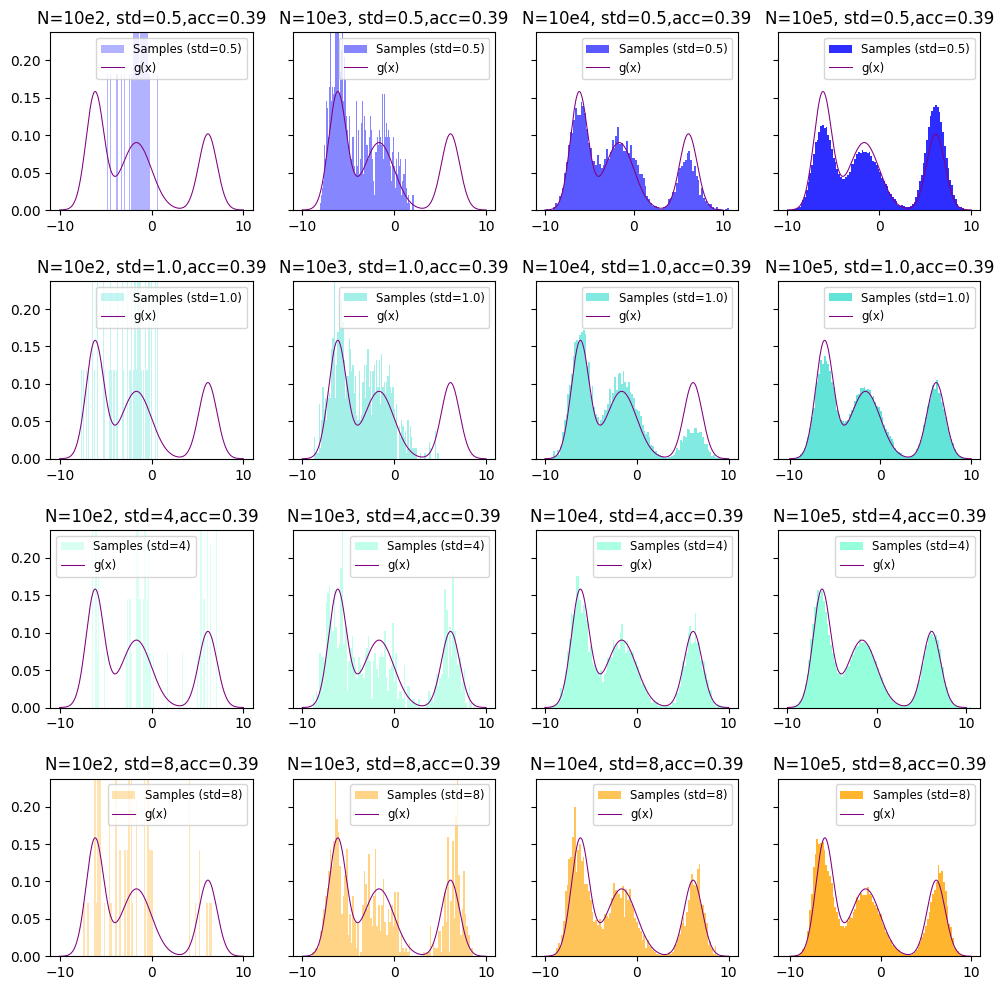

In [136]:
fig, axes = plt.subplots(len(proposal_stds),len(n_samples_list), figsize=(12, 12), sharey=True)
for row, N_samples in enumerate(n_samples_list):
    for col, proposal_std in enumerate(proposal_stds):
        eta = proposal_std ** 2 /2
        x_vals_samples_range = np.linspace(-R, R, 400)
        g_vals_samples_range = [g(x) for x in x_vals_samples_range]
        samples,acc_rate = Metropolis_Hastings_Sampling(g, N_samples, Transition(std=proposal_std,eta=eta),x0=x0)
        alpha = 0.3 + 0.7 * row/4  
        ax = axes[col, row]
        ax.hist(samples, bins=100, density=True, alpha=alpha, label=f'Samples (std={proposal_std})', color=colors[col])
        ax.plot(x_vals_samples_range, g_vals_samples_range, label='g(x)', color='purple', linewidth=0.75)
        ax.set_title(f'N=10e{int(np.log10(N_samples)):,}, std={proposal_std},acc={accept_rate:.2f}')
        ax.legend(fontsize='small')
        ax.set_ylim(0, 1.5 * max(g_vals_samples_range))
        fig.subplots_adjust(hspace=0.4)


*Dimensionality*
In multidimention case, one can sample using the original way, or sample coordinatewise, and using cycle kernal insteand a single highdimensional kernal.

### Continuous Langevin Dynamics

A completely adjustment-free (i.e. accept/reject-free) algorithm is desired to get rid of the accept rate issue.

Discard the adjustment result in Unadjusted Langevin Algorithm (ULA).
$$ x_{t+1} = - \nabla f(x_t)\eta + \sqrt{2\eta}\varepsilon, \ \varepsilon \sim N(0,\mathbb{I}).$$
Regard step size $\eta$ as $\Delta t$, then let $\Delta t \rightarrow 0$, will result in a SDE
$$ dX_t = - \nabla f(X_t) + \sqrt{2}dB_t.$$
Under certain regularity conditions, this converges to $p(x)$. The term $-\nabla f(X_t)$ is in fact $\nabla \log p(X_t)$. This form is called the Langevin Diffusion.

For regularity conditions, see [reference](https://chatgpt.com/share/6815981b-a1a0-8001-8d2b-21beddbba370). For stationarity, the denote the pdf of $X_t$ at time $t$ by $p_t$, then Fokker-Planck equation gives
$$ \partial_t p_t = \nabla \cdot ( p_t \nabla f + \nabla p_t ).$$
For $p(x) \propto e^{-f(x)}$, it remains unchanged.